<img src="https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration/blob/master/static/sdulogo-uk-sort-feb2019.png?raw=true" width=300>

# This Notebook will show a complete pipeline of the flexiblecc module

# TESTESTES

In [2]:
46+4+4+4+94

152

# DGMKDSMG

## Motivation Is a Good Thing, Very Nice!

Camera calibration is an important part of vision algorithm. Stereo vision, 3D, estimation etc. all relies on accurate camera models to accurately depict the world around them. 

Most algorithms introduce their own error but the error inherent in the camera model persists through subsequent algorithms and also often biases the results. Most current vision programs use som version of parametric camera models, usually a refined version of the basic pinhole camera, which makes certain assumptions about the cameras physical properties and about the distribution of distortion. 

If possible it would increase the accuracy of vision algorithms and reduce bias in the results if the camera model could lose its reliance on assumptions and instead be modelled in a more specific and quantifiable way. 

This is the motivation for the generic camera model, which models incoming light in rays on a pr. pixel bases giving many more degrees of freedom and thereby a model more closely resembling the actual camera. 


## TODO:
- Sæt billeder ind med hvor det kunne bruges
- Skriv kort om det med forward og backward

## Import our module flexiblecc and get the calibration dataset
If it is installt we can import else install it with pip 

In [ ]:
import os

In [ ]:
try:
    import flexiblecc as fcc
except ImportError as e:
    !pip install flexiblecc
    import flexiblecc as fcc

Now let's get the dataset if it is not allready pressent 

In [ ]:
data_set = "CalImgs/ChArUco - Sorted/Samsung Galaxy S10 Plus/WideAngle/Fold_1"

In [ ]:
if not os.path.exists("../CalImgs/"):
    if not os.path.exists("Flexible-Camera-Calibration/CalImgs"):
        !git clone https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration 
    datasetpath = "Flexible-Camera-Calibration/"+data_set+"/*.jpg"
else:
    datasetpath = "../"+data_set+"/*.jpg"

Next we can import a copuel of package we will need

In [77]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable
from IPython.display import Video
from IPython.core.display import display, HTML

# Image data

Let's first get all the image files

In [6]:
image_files = glob.glob(datasetpath)

Then we can load them with opencv and convert the to grayscale for the parametric camaer calibration 

In [7]:
color_images = [cv2.imread(f) for f in tqdm(image_files)]
gayscale_images = [cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY) for c_img in tqdm(color_images)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 461.44it/s]


In [8]:
image_shape = color_images[0].shape[:2]

Let's see the images from the data set

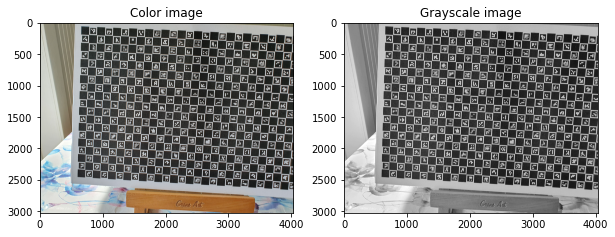

In [9]:
idx = 0

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(color_images[idx], cv2.COLOR_BGR2RGB))
plt.title("Color image")
plt.subplot(122)
plt.imshow(gayscale_images[idx], cmap="gray")
plt.title("Grayscale image")
plt.show()

The dataset contains 157 charuco borad calibration images

# Parametric camera calibration

In [10]:
import flexiblecc.Parametric as parcc

To use the charuco board a set of parameters are neede to define the borad's layout. 

- squaresX: The number of squares in the x axis 
- squaresY: The number of squares in the y axis 
- squareLength: The length of a square in meters 
- markerLength: The length of a marker in meters 
- dictionary: dictionary of markers indicating the type of markers. Can normally be found with cv2.aruco.getPredefinedDictionary

In [11]:
squaresX = 28 
squaresY = 19 
squareLength = 0.01 
markerLength = 0.0075 
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)

Lert's do the calibration for both 5 and 14 distorsion parameters
- 3 + 5 parameters: TODO de modeler der bruges
- 3 + 14 parameters: TODO de modeler der bruges

In [80]:
calibrate_retval_5dp, cameraMatrix_5dp, distCoeffs_5dp, rvecs_5dp, tvecs_5dp, stdDeviationsIntrinsics_5dp, stdDeviationsExtrinsics_5dp, \
    perViewErrors_5dp, charucoCorners_all_5dp, charucoIds_all_5dp, markerCorners_all_5dp, armarkerIds_all_5dp, obj_points_all_5dp, _ = parcc.calibrate_camera_charuco(gayscale_images, squaresX, squaresY,
                                                                                                                                                  squareLength, markerLength, dictionary, flags=0, verbose=0)

calibrate_retval_14dp, cameraMatrix_14dp, distCoeffs_14dp, rvecs_14dp, tvecs_14dp, stdDeviationsIntrinsics_14dp, stdDeviationsExtrinsics_14dp, \
    perViewErrors_14dp, charucoCorners_all_14dp, charucoIds_all_14dp, markerCorners_all_14dp, armarkerIds_all_14dp, obj_points_all_14dp, board = parcc.calibrate_camera_charuco(gayscale_images, squaresX, squaresY,
                                                                                                                                                  squareLength, markerLength, dictionary, verbose=1)

  0%|                                                                                                | 0/30 [00:00<?, ?image/s]

Finding charuco features


100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.84image/s]


Doing camera calibrate
Calibration done


## First let'sa look at where the charuco borads have been in relation to the camera

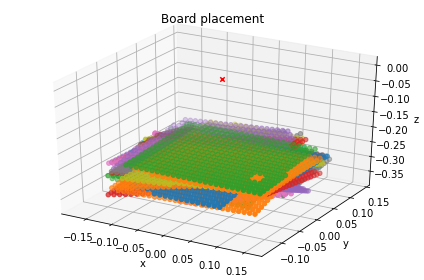

In [14]:
fcc.Metrics.rtvecs_illustration.draw_rtvecs(rvecs_14dp, tvecs_14dp, obj_points_all_14dp)
plt.title("Board placement")
plt.tight_layout()
plt.show()

## Let's look at the distorisen the parametric model has deskribet in the camera

First we define a function there kan givein som points return the undistoret points

In [15]:
def undistort(points):
    return cv2.undistortPoints(points, cameraMatrix_14dp, distCoeffs_14dp, P=cameraMatrix_14dp).reshape(-1, 2)

Then we can give the function to plot_distort to create a distorisin plot

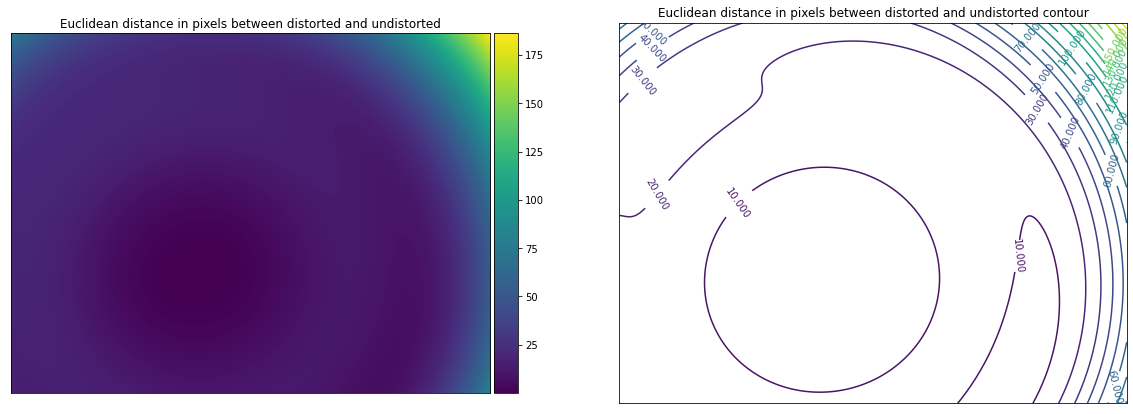

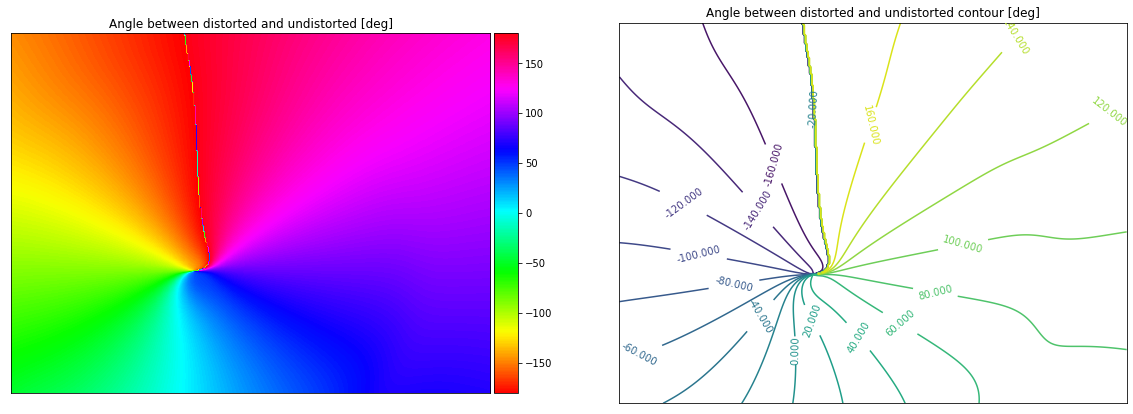

In [71]:
fcc.Metrics.plot_distort(undistort, image_shape, contour_n_levels=20)

## Next we can look for any sytamatic error when reprojectiong the object point to the image plane

This can be done by makeing a voronoi diagram over the angles between the featur points and the correspointing reprojected points

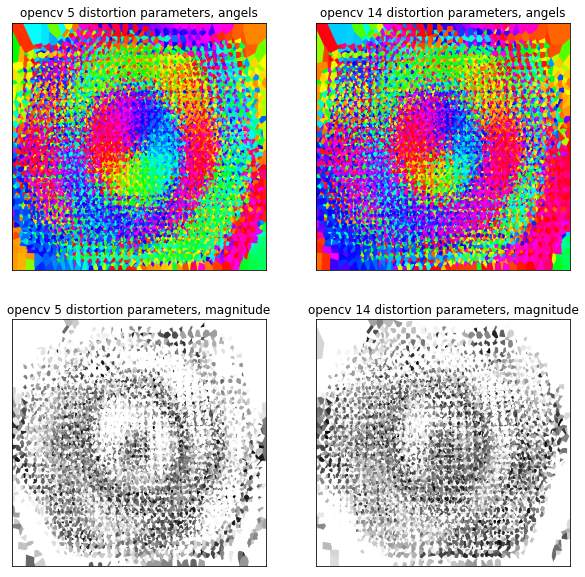

In [82]:
display(HTML("""<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/voronoi.svg" width=200>"""))

img_points_all_5dp, diff_all_5dp, angels_all_5dp, mag_all_5dp = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(charucoCorners_all_5dp, obj_points_all_5dp, rvecs_5dp, tvecs_5dp, cameraMatrix_5dp, distCoeffs_5dp)
img_points_all_14dp, diff_all_14dp, angels_all_14dp, mag_all_14dp = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(charucoCorners_all_14dp, obj_points_all_14dp, rvecs_14dp, tvecs_14dp, cameraMatrix_14dp, distCoeffs_14dp)

def remove_ticks():
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(10,10))

ax = plt.subplot(221)
plt.title("opencv 5 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, angels_all_5dp, ax=ax)
remove_ticks()

ax = plt.subplot(222)
plt.title("opencv 14 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, angels_all_14dp, ax=ax)
remove_ticks()

ax = plt.subplot(223)
plt.title("opencv 5 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, mag_all_5dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(224)
plt.title("opencv 14 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, mag_all_14dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

plt.show()

## Last we can print the RMS reprojection error for the calibrations

In [92]:
table = PrettyTable()
table.field_names = ["Reprojection error", "opencv (3 + 5 parameters)", "opencv (3 + 14 parameters)"]
table.add_row(["RMS:", f"{calibrate_retval_5dp:0.5f}", f"{calibrate_retval_14dp:0.5f}"])
print(table)

+--------------------+---------------------------+----------------------------+
| Reprojection error | opencv (3 + 5 parameters) | opencv (3 + 14 parameters) |
+--------------------+---------------------------+----------------------------+
|        RMS:        |          2.61024          |          2.48643           |
+--------------------+---------------------------+----------------------------+


# Central Model - Generic Calibration

Generic Calibration contain several components to accommodate the more dense model. Instead of just having an equation with a couple of parameters we can apply to the image we have much more dense information about many of the involved pixels. So get ready. 

The fundamental idea In generic calibration is to associate each pixel with a direction from which it receives light. To represent these directions a set of vectors interpolated with a b-spline is used and to map the directions to the camera a bundle adjustment is performed on the vectors with regards to the calibration images. 

### Model representation. 
Each pixel needs a direction and directions are given as vectors in three dimensions, but in order to limit the size of the model not every pixel is assigned a full vector. Instead  a grid is constructed, whose intersections marks evenly spaced pixels over the image. These evenly spaced pixels are all given a vector, and a 2-dimensional b-spline interpolation is mapped to these vectors <strong>(We really need a picture of this)</strong>. The b-spline lets us calculate a direction vector for all the pixel between grid intersection. 
In summary our camera model is a set of vectors, and a b-spline that can interpolate between them. 

### Model Construction 
To construct the model the first thing that is needed is an initial guess of the model that can be used for bundle-adjustment. As usual optimization the better the initial guess the better results and the lower chance we find a non-optimal solution. Therefore as an initial guess we use the parametric calibration results, <strong>(What is our starting guess for B-Spline parameters? do we even have any?)</strong>. Now we can start the bundle adjustment. Bundle adjustment attempts to minimize the reprojection error, which is the difference between a projected image position based on the model and the actual position measured in the image. The projected image position is calculated from the known 3D position of the charuco boards using the camera model and b-spline. From the resulting reprojection error a correction step is calculated with TRS a trust region reflective algorithm and the process is repeated until the reprojection error is minimized. 


## Bundel adjustmen

# TODO:
- Skriv noget her
- Hvilek parameter der bruges til BA

In [34]:
from flexiblecc.CentralModel import BundleAdjustment

# TODO:
- Skriv noget her
- Tag de der nave på parameteren væk i denne version

<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_2.svg" > <img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_1.svg" >

### Prefit

TODO:
- Skriv noget til det her....
- Skriv om pre fit

In [88]:
Video("../static/bspline.mp4", width=800, html_attributes="loop autoplay")

In [46]:
ba = BundleAdjustment(obj_points_all_14dp, rvecs_14dp, tvecs_14dp, charucoCorners_all_14dp, cameraMatrix_14dp, 
                      distCoeffs_14dp, image_shape, cm_stepsize=252, cm_order=2)

Generating sparsity matrix
Starting least squares fitting of CentralModel.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3925e+00                                    1.46e-01    
       1              2         3.0031e+00      3.89e-01       3.46e+00       6.39e-03    
       2              3         3.0000e+00      3.06e-03       6.93e+00       2.19e-08    
       3              5         3.0000e+00      2.66e-15       3.46e+00       4.60e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 3.3925e+00, final cost 3.0000e+00, first-order optimality 4.60e-09.


# TODO:
- Skriv noget her

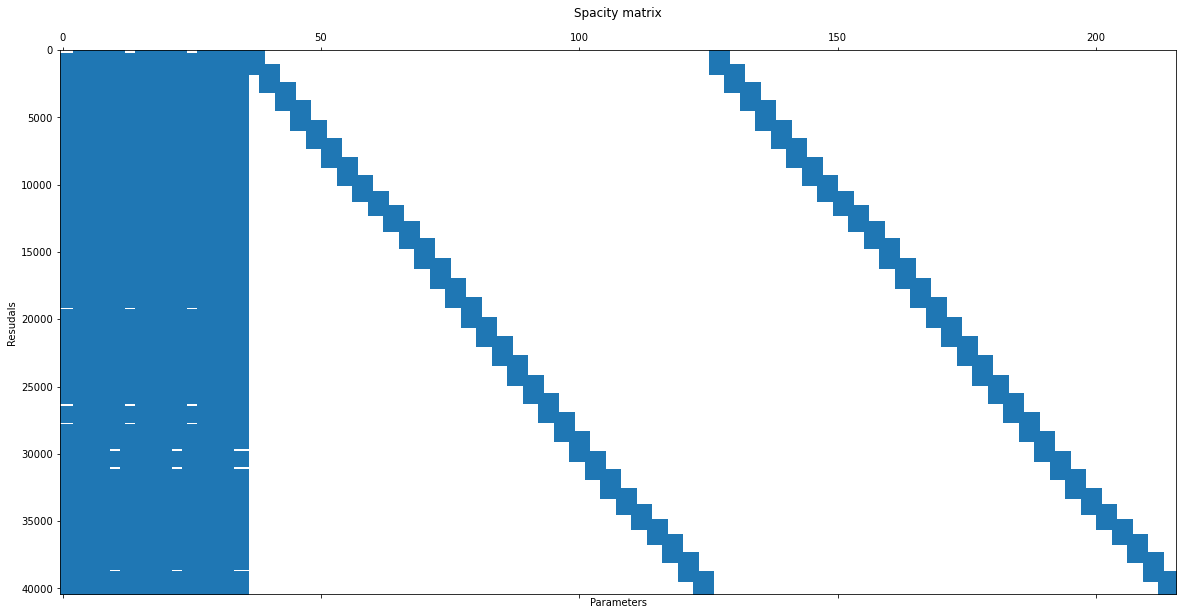

In [89]:
fig, ax = plt.subplots(figsize=[20,10])
plt.title("Spacity matrix")

ax.spy(ba.A, aspect="auto")
plt.xlabel("Parameters")
plt.ylabel("Resudals")

plt.show()

# TODO:
- Skriv noget her
- Forward og backward

In [48]:
cm, res, rvecs_new, tvecs_new = ba.least_squares()

Performing least squares optimization on the control points and position of the chessboards
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0167e+03                                    1.73e+11    
       1              2         5.0167e+03      0.00e+00       0.00e+00       1.73e+11    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 5.0167e+03, final cost 5.0167e+03, first-order optimality 1.73e+11.


New we can save the model for leater use

In [84]:
fcc.CentralModel.cm_save(cm, "cm.npz")

# Results
The two methods can be compared in a single number the residual, which is the RMS of the error, however this number says nothing about the distribution of the error over the image. To visualize this a voronoi diagram is constructed of the direction and one of the magnitude. From the voronoi diagram it can be seen that the parametric camera model contains artifacts or patterns  in the error, and this is where a potential bias in the calibration comes from. The generic model has a more even distribution of the error and this combined with the lower RMS error is why it is a superior method, although also slightly slower. 

### 2D Residul calgulations

# TODO:
- Skriv noget her

<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_3.svg" > <img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/dd3e040c02a82ae2f4a69b7d89f520f70b987b15/static/Residual_Calculation_1.svg">

### Voronoi

In [55]:
cm_rms, residuals_2D, estimated_points_2D, correct_points_2D = ba.calc_residuals_2D(res.x, return_points_2D=True, verbose=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:44<00:00,  5.47s/image]


In [56]:
image_points = np.concatenate(correct_points_2D)
project_points = np.concatenate(estimated_points_2D)
imp, diff, angels, mag = fcc.Metrics.voronoi.cal_angles_and_mag(image_points, project_points)

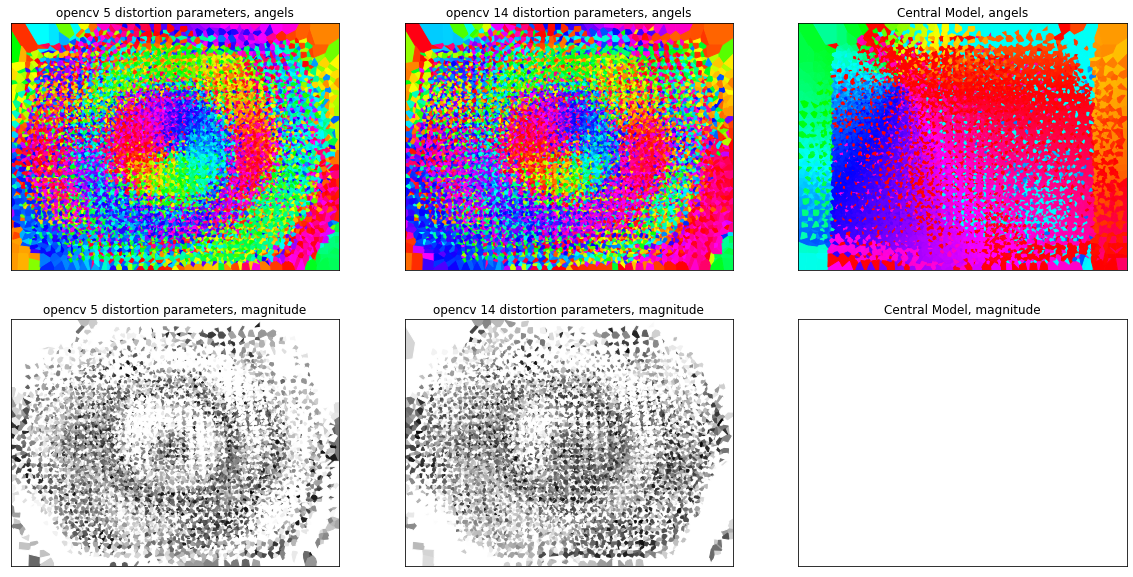

In [57]:
plt.figure(figsize=(20,10))

ax = plt.subplot(231)
plt.title("opencv 5 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, angels_all_5dp, ax=ax)
remove_ticks()

ax = plt.subplot(232)
plt.title("opencv 14 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, angels_all_14dp, ax=ax)
remove_ticks()

ax = plt.subplot(233)
plt.title("Central Model, angels")
fcc.Metrics.voronoi.plot_voronoi(imp, angels, ax=ax)
remove_ticks()

ax = plt.subplot(234)
plt.title("opencv 5 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, mag_all_5dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(235)
plt.title("opencv 14 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, mag_all_14dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(236)
plt.title("Central Model, magnitude")
fcc.Metrics.voronoi.plot_voronoi(imp, mag, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

plt.show()

# TODO:
- Skriv noget her
- Plot normalitet osv på reseduals

In [91]:
table = PrettyTable()
table.field_names = ["Reprojection error", "opencv (3 + 5 parameters)", "opencv (3 + 14 parameters)", f"Central Model ({np.product(cm.a.shape)} parameters)"]
table.add_row(["RMS:", f"{calibrate_retval_5dp:0.5f}", f"{calibrate_retval_14dp:0.5f}", f"{cm_rms:0.5f}"])
print(table)

+--------------------+---------------------------+----------------------------+-------------------------------+
| Reprojection error | opencv (3 + 5 parameters) | opencv (3 + 14 parameters) | Central Model (36 parameters) |
+--------------------+---------------------------+----------------------------+-------------------------------+
|        RMS:        |          2.61024          |          2.48643           |          67854.11138          |
+--------------------+---------------------------+----------------------------+-------------------------------+
